# Stability analysis of the eCD gate

This notebook analyzes the stability of the eCD gate under relative Rabi pulse and absolute detuning errors. The code infrastructure used is the same as for the performance analysis for different sets of parameters. The respective functions can be found in the "helpers.py" python file. Scans of both the Rabi pulse and detuning error are performed independently and saved as .txt files to be compared to the BOO performance in the "comparison_stability.ipynb" notebook.

In [1]:
#Package importation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors

from qutip import *
from scipy.integrate import quad
from helpers import *

qutip.settings.auto_tidyup = False

## Test evolution of $H_{eCD}$ for initial Bell state

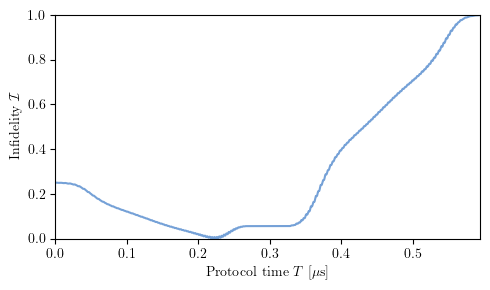

In [2]:
#Define values of constants
T, steps = 0.54, 1000
Ttot, tau = T + T/10, 0.175*T
iters = 5000
Omax, Dmax = 23*2*np.pi, 17*2*np.pi
V = 2500*2*np.pi
psi_in, psi_exp = (e0+e4).unit(), (e0-e4).unit()


# Define arrays and dictionaries
args   = {"T":T, "Omax":Omax, "Dmax":Dmax, "tau":tau, 'T2':T/10, 'V':V, 'omg':0}
tvals  = np.linspace(0, Ttot, steps)
itvals = np.linspace(0, Ttot, iters)

# Get Hamiltonians
H_0    = fH_0(V, args)
dt_H_0 = fdt_H_0(V, args)
H_V    = M5*V
f1, f2 = f1_f2_num(H_0, dt_H_0, iters, args)

# Restrict eCD pulse to Omega_max and define H_E
fmax = np.max([np.max(f1(tvals)), np.max(f2(tvals))])
omg  = Omax ** 2 / (2 * fmax)
args['omg'] = omg

#Calculate time evolutions and fidelities
U_E  = propH_E_id(f1, f2, steps, args)
fids = [propagator_fid(U_E[i], CZ_perfect) for i in range(steps)]

#Draw time evo of targeted state
fig, ax0 = plt.subplots(1, 1, figsize = (5, 3))

ax0.plot(tvals, fids, color = col1)
ax0.set_ylim(0, 1)
ax0.set_xlim(0, Ttot)
ax0.set_xlabel('Protocol time $T$ [$\mu$s]')
ax0.set_ylabel('Infidelity $\mathcal{I}$')

plt.tight_layout()
plt.show()

## Performing the Rabi pulse error analysis

In [3]:
#Define parameters
T       = 0.54
steps   = 200
iters   = 500
Omax    = 23*2*np.pi
Dmax    = 17*2*np.pi
Vvals   = np.array([250, 2500])*2*np.pi
d_err   = 0

# Define error array and empty infidelities
c12_errs      = np.linspace(-0.3, 0.3, 10)
infids_c12err = np.zeros([2, len(c12_errs)])

for j, V in enumerate(Vvals):
    
    # Get matrices
    H_V    = M5*V
    H_0    = fH_0(V, args)
    dt_H_0 = fdt_H_0(V, args)
    f1, f2 = f1_f2_num(H_0, dt_H_0, iters, args)
    
    # Restrict eCD pulse to Omega_max and define H_E
    fmax = np.max([np.max(f1(tvals)), np.max(f2(tvals))])
    omg  = Omax ** 2 / (2 * fmax)
    
    for i, c12_err in enumerate(c12_errs):

        # Protocol time
        Ttot = T + T/10
        tau  = 0.175*T

        # Define arrays and dictionary
        tvals  = np.linspace(0, Ttot, steps)
        itvals = np.linspace(0, Ttot, iters)
        args   = {"T":T, "Omax":Omax, "Dmax":Dmax, "tau":tau, 'T2':T/10, 'V':V, 'omg':omg}
        
        # Get time evolution operator
        U_E                = propH_E_id_err(f1, f2, c12_err, d_err, steps, args)
        infids_c12err[j, i] = 1 - propagator_fid(U_E[-1], CZ_perfect)
    
    print(f'finished V/2π = {np.rint(V/(2*np.pi))} MHz')

# Save result as .txt
np.savetxt('../data/omg_err_ecd.txt', [c12_errs, infids_c12err[0], infids_c12err[1]]) 
print('finished all')

finished V/2π = 250.0 MHz
finished V/2π = 2500.0 MHz
finished all


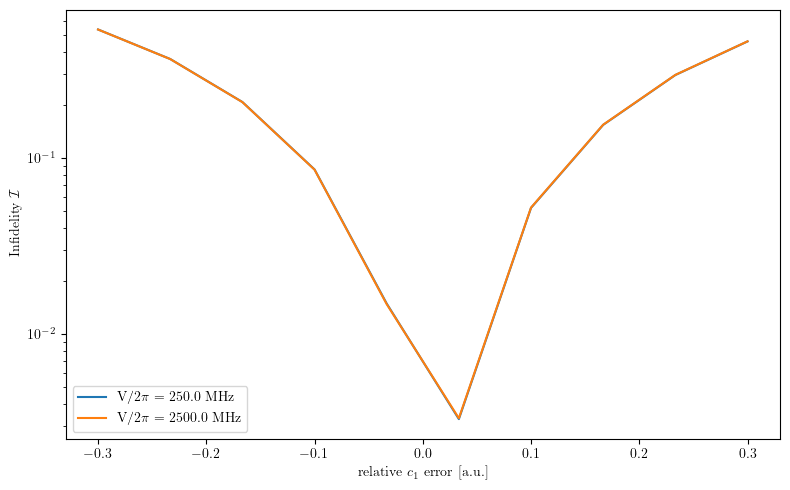

In [10]:
#Draw the result
fig, ax0 = plt.subplots(1, 1, figsize = (8, 5))

for j, V in enumerate(Vvals):
    ax0.plot(c12_errs, infids_c12err[j], label = f'V/2$\\pi$ = {np.rint(V/(2*np.pi))} MHz')
ax0.set_yscale('log')
ax0.set_xlabel('relative $c_1$ error [a.u.]')
ax0.set_ylabel('Infidelity $\mathcal{I}$')
ax0.legend()

plt.tight_layout()
plt.show()  

## Performing the detuning error analysis

In [6]:
#Define parameters
T      = 0.54
steps  = 500
iters  = 500
Omax   = 23*2*np.pi
Dmax   = 17*2*np.pi
Vvals  = np.array([250, 2500])*2*np.pi
c1_err = 0

# Define error array and empty infidelities
d_errs      = np.linspace(-0.2, 0.2, 10) * 2 * np.pi
infids_derr = np.zeros([2, len(d_errs)])

for j, V in enumerate(Vvals):
    
    # Get matrices
    H_V       = M5*V
    H_0       = fH_0(V, args)
    dt_H_0    = fdt_H_0(V, args)
    f1, f2    = f1_f2_num(H_0, dt_H_0, iters, args)
    
    #Restrict eCD pulse to Omega_max and define H_E
    fmax        = np.max([np.max(f1(tvals)), np.max(f2(tvals))])
    omg         = Omax ** 2 / (2 * fmax)
    
    for i, d_err in enumerate(d_errs):

        # Protocol time
        Ttot = T + T/10
        tau  = 0.175*T

        # Define arrays and dictionary
        tvals  = np.linspace(0, Ttot, steps)
        itvals = np.linspace(0, Ttot, iters)
        args   = {"T":T, "Omax":Omax, "Dmax":Dmax, "tau":tau, 'T2':T/10, 'V':V, 'omg':omg}

        # Get time evolution operator
        U_E               = propH_E_id_err(f1, f2, c12_err, d_err, steps, args)
        infids_derr[j, i] = 1 - propagator_fid(U_E[-1], CZ_perfect)
    
    print(f'finished V/2π = {np.rint(V/(2*np.pi))} MHz')

# Save result as .txt
np.savetxt('../data/delta_err_ecd.txt', [d_errs, infids_derr[0], infids_derr[1]]) 
print('finished all')

finished V/2π = 250.0 MHz
finished V/2π = 2500.0 MHz
finished all


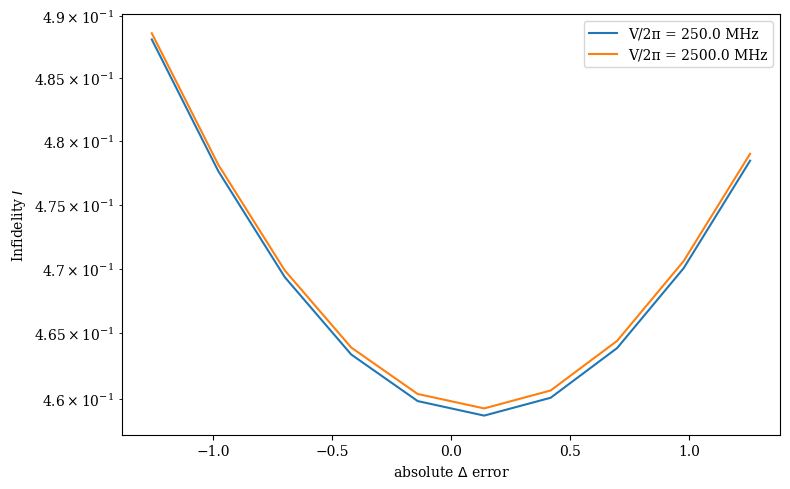

In [7]:
#Draw the fidelities
fig, ax0 = plt.subplots(1, 1, figsize = (8, 5))

for j, V in enumerate(Vvals):
    ax0.plot(d_errs, infids_derr[j], label = f'V/2π = {np.rint(V/(2*np.pi))} MHz')
ax0.set_yscale('log')
ax0.set_xlabel('absolute $\Delta$ error')
ax0.set_ylabel('Infidelity $I$')
ax0.legend()

plt.tight_layout()
plt.show()  